# K-Means Clustering for Imagery Analysis
> In this post, we will use a K-means algorithm to perform image classification. Clustering isn't limited to the consumer information and population sciences, it can be used for imagery analysis as well. Leveraging Scikit-learn and the MNIST dataset, we will investigate the use of K-means clustering for computer vision.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Machine_Learning, Natural_Language_Processing, Vision]
- image: images/mnist_kmeans.png

## Required Packages

In [1]:
import sys
import sklearn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Version Check

In [2]:
print('Python: {}'.format(sys.version))
print('Scikit-learn: {}'.format(sklearn.__version__))
print('NumPy: {}'.format(np.__version__))

Python: 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
Scikit-learn: 1.0.2
NumPy: 1.21.6


## Load Datasets
For the convenience, we will load the MNIST dataset from tensorflow Keras Library. Or you can download it directly from [here](http://yann.lecun.com/exdb/mnist/).

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Print shape of dataset
print("Training: {}".format(X_train.shape))
print("Test: {}".format(X_test.shape))

11490434/11490434 [==============================] - 0s 0us/step
Training: (60000, 28, 28)
Test: (10000, 28, 28)


As you can see, the original dataset contains 28x28x1 pixel image. Let's print it out, and what it looks like.

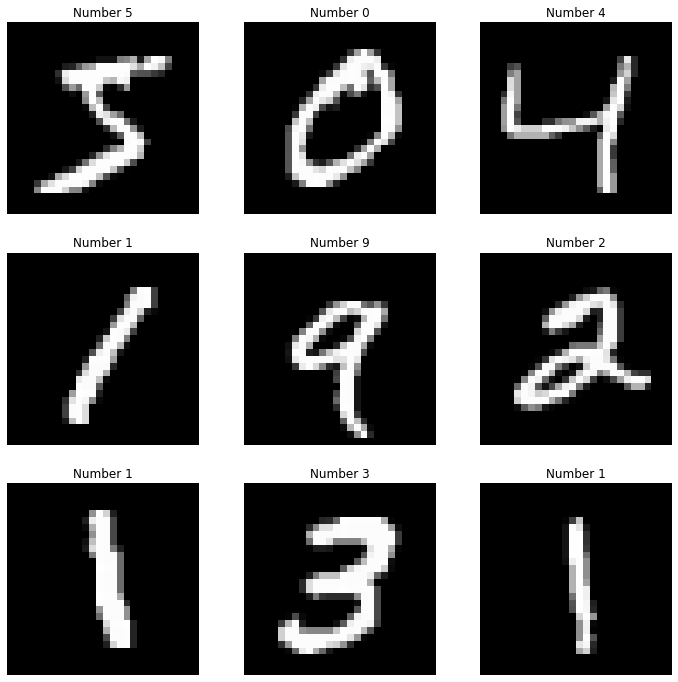

In [6]:
fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.imshow(X_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
    
# display the figure
plt.show()

## Preprocessing

### Reshape
Images stored as NumPy arrays are 2-dimensional arrays. However, the K-means clustering algorithm provided by scikit-learn ingests 1-dimensional arrays; as a result, we will need to reshape each image. (in other words, we need to **flatten** the data)

Clustering algorithms almost always use 1-dimensional data. For example, if you were clustering a set of X, Y coordinates, each point would be passed to the clustering algorithm as a 1-dimensional array with a length of two (example: [2,4] or [-1, 4]). If you were using 3-dimensional data, the array would have a length of 3 (example: [2, 4, 1] or [-1, 4, 5]).

MNIST contains images that are 28 by 28 pixels; as a result, they will have a length of 784 once we reshape them into a 1-dimensional array.

In [7]:
# Convert each image to 1d array (28x28 -> 784x1)
X_train = X_train.reshape(len(X_train), -1)
print(X_train.shape)

(60000, 784)


### Normalization
Also, One approach to help training is **normalization**. In order to do this, we need to convert each pixel value into 0 to 1 range. The maximum value of pixel in grayscale is 255, so it can normalize it by dividing 255. Of course, its overall shape is same as before.

In [9]:
# Normalize the data to 0 - 1
X_train = X_train.astype(np.float32) / 255.

## Applying K-means Clustering
Since the size of the MNIST dataset is quite large, we will use the **mini-batch** implementation of k-means clustering (`MiniBatchKMeans`) provided by scikit-learn. This will dramatically reduce the amount of time it takes to fit the algorithm to the data.

Here, we just choose the `n_clusters` argument to the `n_digits`(the size of unique labels, in our case, 10), and set the default parameters in `MiniBatchKMeans`.

And as you know that, K-means clustering is one of the unsupervised learning. That means it doesn't require any label to train.

In [10]:
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(y_train))
print(n_digits)

10


In [11]:
kmeans = MiniBatchKMeans(n_clusters=n_digits)
kmeans.fit(X_train)

MiniBatchKMeans(n_clusters=10)

We can find the labels of each input that is generated from K means model.

In [12]:
kmeans.labels_

array([6, 7, 8, ..., 4, 7, 0], dtype=int32)

But these are not real label of each image, since the output of the `kmeans.labels_` is just group id for clustering. For example, 6 in `kmeans.labels_` has similar features with another 6 in `kmeans.labels_`. There is no more meaning from the label.

To match it with real label, we can tackle the follow things:

- Combine each images in the same group
- Check Frequency distribution of actual labels (using `np.bincount`)
- Find the Maximum frequent label (through `np.argmax`), and set the label.

In [13]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    # Loop through the clusters
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [15]:
cluster_labels = infer_cluster_labels(kmeans, y_train)
X_clusters = kmeans.predict(X_train)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(y_train[:20])

[3 0 4 1 9 8 1 3 1 8 3 1 3 6 1 7 6 8 1 8]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


As a result, some predicted label is mismatched, but most of case, the k-means model can correctly cluster of each group.

## Evaluating Clustering Algorithm
With the functions defined above, we can now determine the accuracy of our algorithms. Since we are using this clustering algorithm for classification, accuracy is ultimately the most important metric; however, there are other metrics out there that can be applied directly to the clusters themselves, regardless of the associated labels. Two of these metrics that we will use are **inertia** and **homogeneity**. (See the detailed description of [homogeneity_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html))

Furthermore, earlier we made the assumption that K = 10 was the appropriate number of clusters; however, this might not be the case. Let's fit the K-means clustering algorithm with several different values of K, than evaluate the performance using our metrics.

In [16]:
from sklearn.metrics import homogeneity_score

def calc_metrics(estimator, data, labels):
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    # Inertia
    inertia = estimator.inertia_
    print("Inertia: {}".format(inertia))
    # Homogeneity Score
    homogeneity = homogeneity_score(labels, estimator.labels_)
    print("Homogeneity score: {}".format(homogeneity))
    return inertia, homogeneity

In [17]:
from sklearn.metrics import accuracy_score

clusters = [10, 16, 36, 64, 144, 256]
iner_list = []
homo_list = []
acc_list = []

for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters=n_clusters)
    estimator.fit(X_train)
    
    inertia, homo = calc_metrics(estimator, X_train, y_train)
    iner_list.append(inertia)
    homo_list.append(homo)
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, y_train)
    prediction = infer_data_labels(estimator.labels_, cluster_labels)
    
    acc = accuracy_score(y_train, prediction)
    acc_list.append(acc)
    print('Accuracy: {}\n'.format(acc))

Number of Clusters: 10
Inertia: 36.592124938964844
Homogeneity score: 0.4544195206395852
Accuracy: 0.5242333333333333

Number of Clusters: 16
Inertia: 34.00279235839844
Homogeneity score: 0.5796981854508048
Accuracy: 0.6856333333333333

Number of Clusters: 36
Inertia: 29.962045669555664
Homogeneity score: 0.6848959187528234
Accuracy: 0.76315

Number of Clusters: 64
Inertia: 27.841224670410156
Homogeneity score: 0.7447565067789021
Accuracy: 0.8244

Number of Clusters: 144
Inertia: 24.980728149414062
Homogeneity score: 0.8090978876022559
Accuracy: 0.8688

Number of Clusters: 256
Inertia: 23.133268356323242
Homogeneity score: 0.8423450218270201
Accuracy: 0.8969333333333334



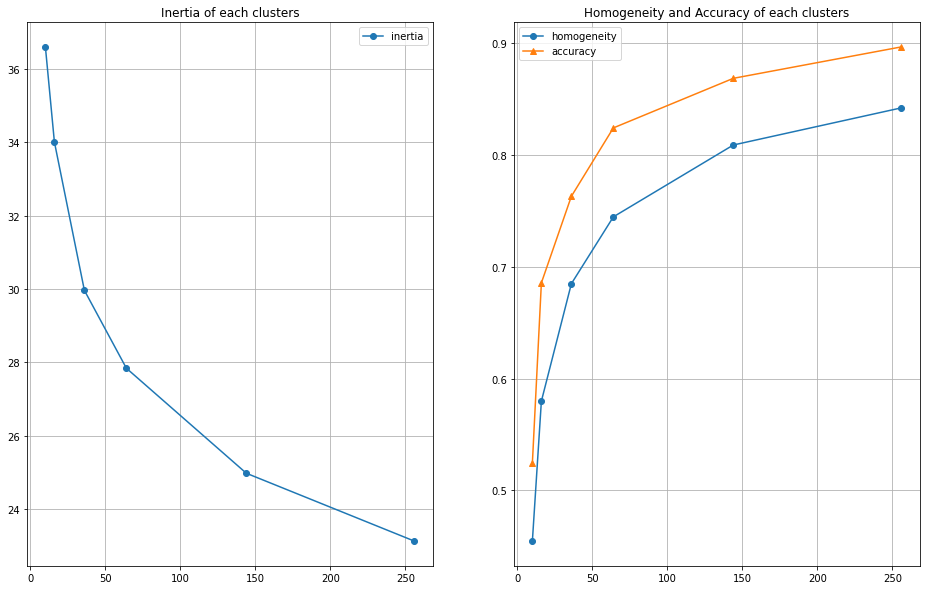

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].plot(clusters, iner_list, label='inertia', marker='o')
ax[1].plot(clusters, homo_list, label='homogeneity', marker='o')
ax[1].plot(clusters, acc_list, label='accuracy', marker='^')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].grid('on')
ax[1].grid('on')
ax[0].set_title('Inertia of each clusters')
ax[1].set_title('Homogeneity and Accuracy of each clusters')
plt.show()

As a result, we found out that when the K value is increased, the accuracy and homogeneity is also increased. We can also check the performance on test dataset.

In [20]:
X_test = X_test.reshape(len(X_test), -1)
X_test = X_test.astype(np.float32) / 255.

kmeans = MiniBatchKMeans(n_clusters=256)
kmeans.fit(X_test)

cluster_labels = infer_cluster_labels(kmeans, y_test)

test_clusters = kmeans.predict(X_test)
prediction = infer_data_labels(kmeans.predict(X_test), cluster_labels)
print('Accuracy: {}'.format(accuracy_score(y_test, prediction)))

Accuracy: 0.8959


There we have MiniBatchKmeans Clustering model with almost 90% accuracy. One definite way to check the model performance is to visualize the real image.

For the convenience, we decrease the `n_clusters` to 36.

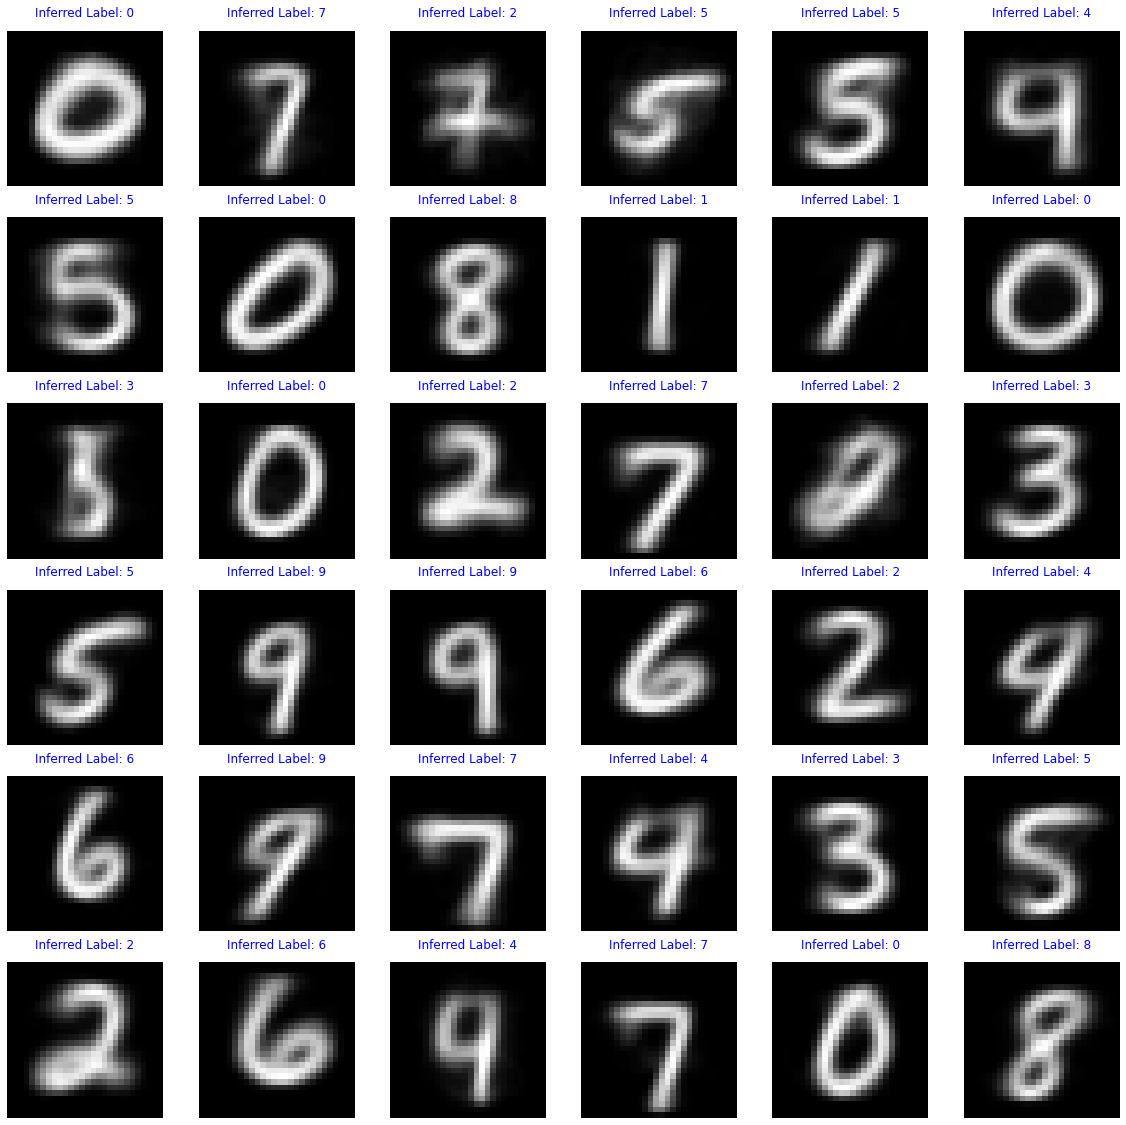

In [21]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X_test)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, y_test)
prediction = infer_data_labels(kmeans.predict(X_test), cluster_labels)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():        
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key), color='blue')
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
plt.show()

## Summary
Through this post, we built the K means clustering model for MNIST digit classification. To do this, we applied preprocessing steps like reshape and normalization. And the model performance is changed in depends on n_clusters. After that, we can make MNIST classifier with almost 90%.